In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from fried_liver_otb import select_board

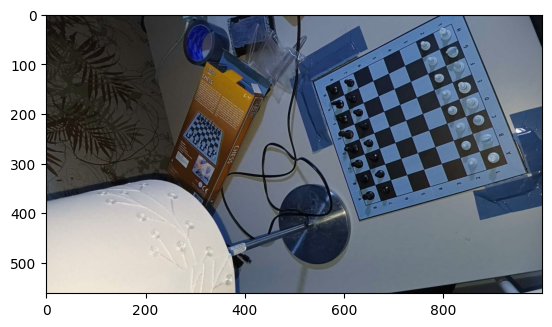

In [ ]:
#img_raw = cv2.imread("resources/nighttime_desk_capture.jpg")
#plt.imshow(img_raw)

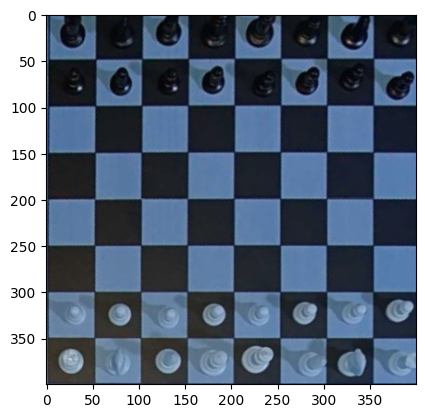

In [ ]:
#board = select_board.transform_board(img_raw[0:400,550:950,:])
#plt.imshow(board)

In [ ]:
#cv2.imwrite("resources/nighttime_desk_capture_clean.jpg", board)

True

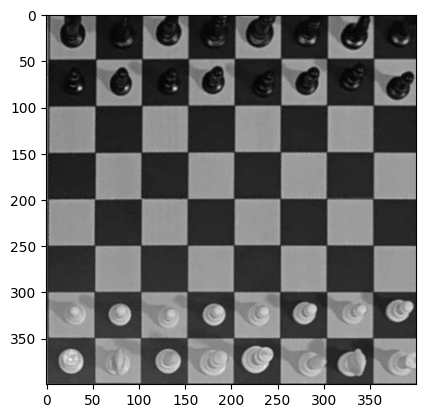

In [12]:
board = cv2.imread("resources/nighttime_desk_capture_clean.jpg")
grey = cv2.cvtColor(board, cv2.COLOR_BGR2GRAY)
plt.imshow(grey, cmap="grey")

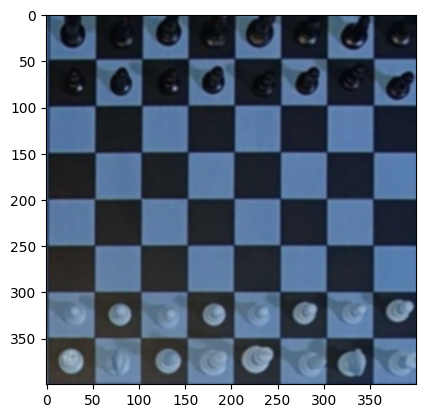

In [13]:
blurred = cv2.GaussianBlur(board, (5, 5), 0)
plt.imshow(blurred, cmap="grey")

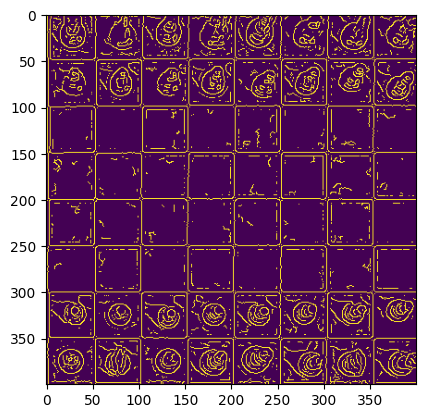

In [18]:
edges = cv2.Canny(blurred, 10, 20)
plt.imshow(edges)